In [614]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [615]:
!ls

catboost_info  gdrive  sample_data


In [616]:
!pip install catboost -q

In [617]:
!pip install phik -q

In [618]:
!pip install imblearn -q

In [619]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

import warnings
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay)

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder,
    OneHotEncoder
    )
from sklearn.compose import ColumnTransformer

import time


from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [620]:
# настраиваем отображение таблиц
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [621]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [622]:
df_main = pd.read_csv('/content/gdrive/MyDrive/Мастерская_2/apparel-purchases.csv')
df_for_merge = pd.read_csv('/content/gdrive/MyDrive/Мастерская_2/apparel-messages.csv')
target = pd.read_csv('/content/gdrive/MyDrive/Мастерская_2/apparel-target_binary.csv')

In [623]:
#создадим функцию которая ищет дубликаты и удаляет их.
def drop_duplicates(df):
    '''Показывает количество дубликатов и при необходимости удаляет'''
    duplicated = df.duplicated().sum()
    print(f'Найдено {duplicated} дублей')
    if duplicated > 0:
        df = df.drop_duplicates()
        duplicated = df.duplicated().sum()
        print(f'После удаления осталось {duplicated} дублей')
    return df

In [624]:
def dataframe_info(df):
    ''' Вывод информации о датафрейме `df`. Функционал схож с методом `pd.DataFrame.info()`

    Дополнительно: вывод процента заполненных (non-null) значений, количестве дублей
    '''
    info = (pd.DataFrame({
        'notNA': df.count(), 'notNA, %': df.count()/df.shape[0]*100,
        'dtype': df.dtypes})
        .style.bar(subset='notNA, %', vmin=0, color='lightblue')
        .format("{:.2f}", subset=['notNA, %'])
    )
    print('DataFrame shape  : {} rows, {} columns'.format(
        df.shape[0], df.shape[1]))
    print('Memory usage     : {:.2f} MB'.format(
        df.memory_usage().sum()/1024/1024))
    print('Duplicates count :', df.duplicated().sum())
    return info

In [625]:
display(df_for_merge.head())
display(target.head())
display(df_main.head())

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


В датафрейме df_for_merge 12 миллионов строк работать с ним неудобно и очень долго, к тому же датафрейм с целевым признаком имеет 49 тысяч строк. Смержу все датафреймы для более удобной работы и после уже начну работать по каждому признаку.

In [626]:
# Изменим похожие названия колонок, чтобы при слиянии было хорошо понятно где что.
df_main.rename(columns={'date':'date_purchases'}, inplace = True)
df_for_merge.rename(columns={'date':'date_messages'}, inplace = True)

In [627]:
#drop_duplicates(df_for_merge)

In [628]:
#drop_duplicates(df_main)

In [629]:
drop_duplicates(target)

Найдено 0 дублей


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
...,...,...
49844,1515915626010261344,0
49845,1515915626010266132,0
49846,1515915626010439406,0
49847,1515915626010443527,0


In [630]:
semi_df = pd.merge(target, df_main, how = 'left', on = 'client_id', indicator = True).reindex(target.index)

In [631]:
semi_df.head()

,client_id,target,quantity,price,category_ids,date_purchases,message_id,_merge
0,1515915625468060902,0,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,both
1,1515915625468060902,0,1,1999.0,"['4', '28', '260', '420']",2022-05-27,1515915625468060902-4617-6290657dac196,both
2,1515915625468060902,0,1,1299.0,"['4', '27', '1828', '1599']",2022-05-27,1515915625468060902-4617-6290657dac196,both
3,1515915625468060902,0,1,1999.0,"['4', '28', '260', '420']",2022-05-27,1515915625468060902-4617-6290657dac196,both
4,1515915625468060902,0,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,both


In [632]:
semi_df.drop(columns = '_merge', inplace=True)

In [633]:
data_frame = pd.merge(semi_df, df_for_merge, how = 'left', on = ['client_id', 'message_id']).reindex(target.index)

In [634]:
data_frame.drop_duplicates(inplace=True)

In [635]:
data_frame['date_purchases']= pd.to_datetime(data_frame['date_purchases'])
data_frame['date_messages']= pd.to_datetime(data_frame['date_messages'])

In [636]:
# Итоговый датафрейм.
dataframe_info(data_frame)

DataFrame shape  : 32344 rows, 12 columns
Memory usage     : 3.21 MB
Duplicates count : 0


,notNA,"notNA, %",dtype
client_id,32344,100.00,int64
target,32344,100.00,int64
quantity,32344,100.00,int64
price,32344,100.00,float64
category_ids,32344,100.00,object
date_purchases,32344,100.00,datetime64[ns]
message_id,32344,100.00,object
bulk_campaign_id,31770,98.23,float64
event,31770,98.23,object
channel,31770,98.23,object


In [637]:
# данные столбцы непонадобятся
data_frame.drop('created_at', axis=1, inplace=True)
data_frame.drop('message_id', axis=1, inplace=True)
data_frame = data_frame.reset_index(drop=True)

In [638]:
display(data_frame.head())

,client_id,target,quantity,price,category_ids,date_purchases,bulk_campaign_id,event,channel,date_messages
0,1515915625468060902,0,1,199.0,"['4', '27', '176', '458']",2022-05-27,4617.0,send,email,2022-05-27
1,1515915625468060902,0,1,199.0,"['4', '27', '176', '458']",2022-05-27,4617.0,open,email,2022-05-27
2,1515915625468060902,0,1,199.0,"['4', '27', '176', '458']",2022-05-27,4617.0,click,email,2022-05-27
3,1515915625468060902,0,1,199.0,"['4', '27', '176', '458']",2022-05-27,4617.0,click,email,2022-05-27
4,1515915625468060902,0,1,199.0,"['4', '27', '176', '458']",2022-05-27,4617.0,purchase,email,2022-05-27


In [639]:
data_frame.describe()

,client_id,target,quantity,price,date_purchases,bulk_campaign_id,date_messages
count,3.234400e+04,32344.000000,32344.000000,32344.000000,32344,31770.000000,31770
mean,1.515916e+18,0.040069,1.012058,1329.078005,2022-12-23 13:50:30.126144,8060.696191,2022-12-19 14:00:09.518413568
min,1.515916e+18,0.000000,1.000000,1.000000,2022-05-16 00:00:00,3169.000000,2022-05-19 00:00:00
25%,1.515916e+18,0.000000,1.000000,560.000000,2022-07-16 00:00:00,4832.000000,2022-07-15 00:00:00
50%,1.515916e+18,0.000000,1.000000,1049.000000,2022-11-26 00:00:00,7105.000000,2022-11-16 00:00:00
75%,1.515916e+18,0.000000,1.000000,1799.000000,2023-05-05 00:00:00,11760.000000,2023-04-29 00:00:00
max,1.515916e+18,1.000000,4.000000,24499.000000,2024-02-16 00:00:00,14624.000000,2024-02-14 00:00:00
std,4.692655e+04,0.196125,0.123499,1248.228620,NaN,3637.945211,NaN


<Axes: ylabel='count'>

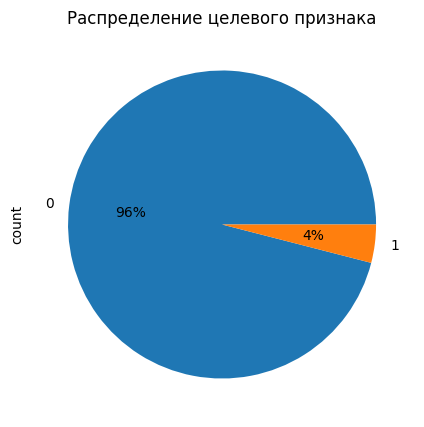

In [640]:
# Посмотрим на распределение целевого признака:
display(data_frame['target'].value_counts().plot(y='count', kind='pie', figsize=(5, 5), autopct='%.0f%%'))
plt.title('Распределение целевого признака')
plt.show()
#data_frame['target'].value_counts().describe()

Наблюдаем дисбаланс классов

,count
event,
click,12007
purchase,8853
open,5771
send,5133
hard_bounce,4
complain,2


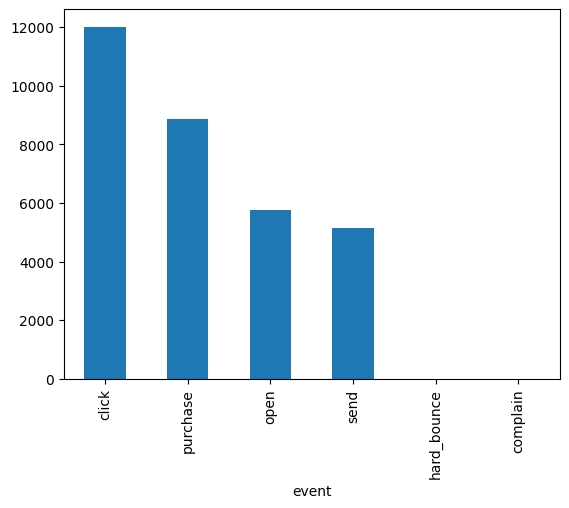

In [641]:
products_in_the_order = data_frame['event'].value_counts()
products_in_the_order.plot.bar()
data_frame['event'].value_counts()

,count
quantity,
1,32002
2,300
3,36
4,6


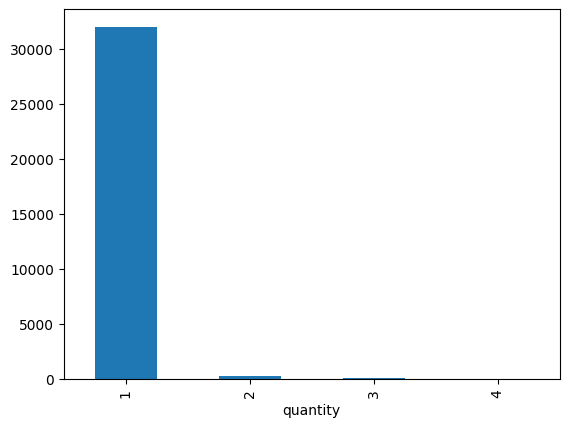

In [642]:
products_in_the_order = data_frame['quantity'].value_counts().head(7)
products_in_the_order.plot.bar()
data_frame['quantity'].value_counts()

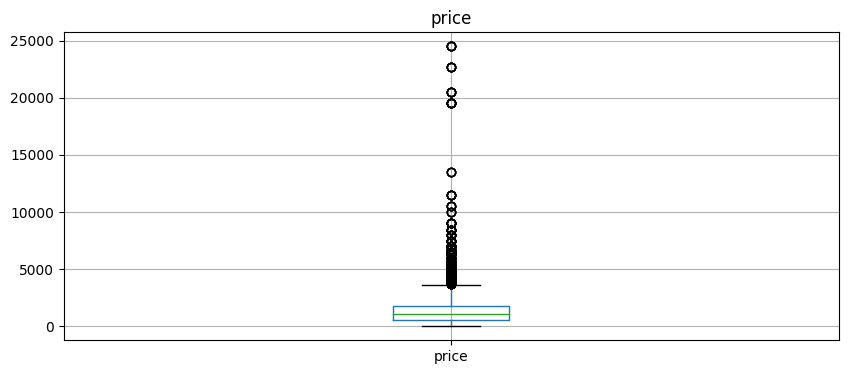

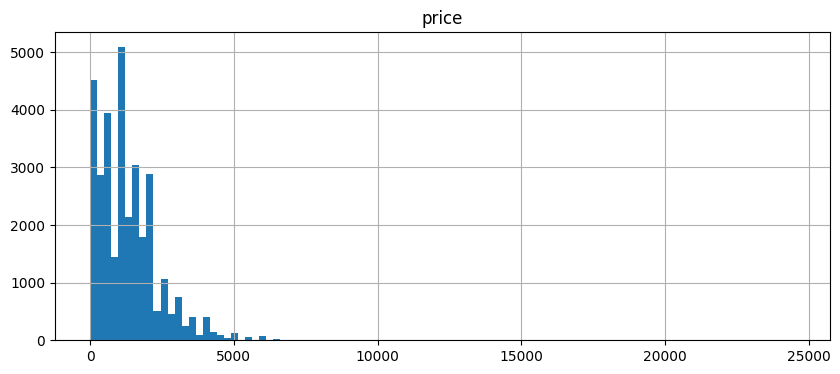

Количество строк равное нулю - 0


In [643]:
column = 'price'
data_frame.boxplot(column=column, figsize=(10,4))
plt.title(column)
plt.show()
data_frame[column].hist(bins=100, figsize=(10,4))
plt.title(column)
plt.show()
print('Количество строк равное нулю -', data_frame[data_frame[column] == 0][column].count())

data_frame = data_frame[data_frame[column] > 0]

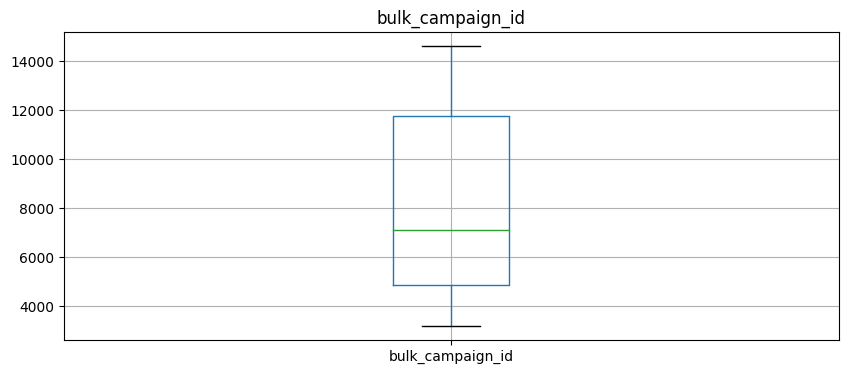

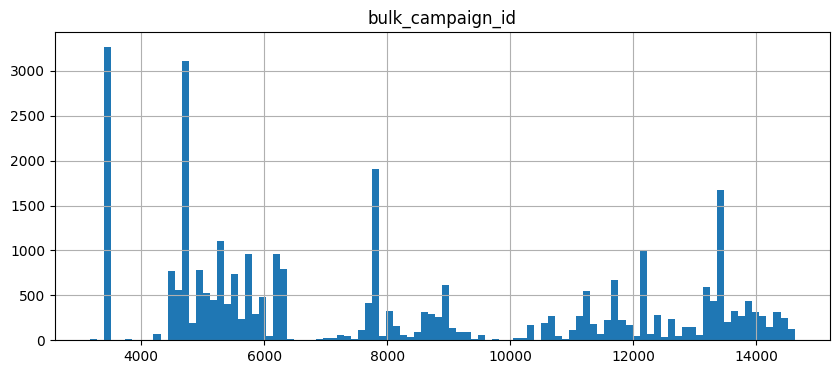

Количество строк равное нулю - 0


In [644]:
column = 'bulk_campaign_id'
data_frame.boxplot(column=column, figsize=(10,4))
plt.title(column)
plt.show()
data_frame[column].hist(bins=100, figsize=(10,4))
plt.title(column)
plt.show()
print('Количество строк равное нулю -', data_frame[data_frame[column] == 0][column].count())

data_frame = data_frame[data_frame[column] > 0]

In [645]:
dataframe_info(data_frame)

DataFrame shape  : 31770 rows, 10 columns
Memory usage     : 2.67 MB
Duplicates count : 7587


,notNA,"notNA, %",dtype
client_id,31770,100.00,int64
target,31770,100.00,int64
quantity,31770,100.00,int64
price,31770,100.00,float64
category_ids,31770,100.00,object
date_purchases,31770,100.00,datetime64[ns]
bulk_campaign_id,31770,100.00,float64
event,31770,100.00,object
channel,31770,100.00,object
date_messages,31770,100.00,datetime64[ns]


In [646]:
# Пробовал вычислить дельту между отправкой сообщения об акции и покупкой товара, но очень много отрицательных значений получил,
# для модели ценности это не принесет.
# data_frame['diff_days'] =(data_frame['date_messages'] - data_frame['date_purchases']) / np.timedelta64 ( 1 , 'D')
# data_frame['diff_days'].value_counts()

In [647]:
#nen = data_frame['category_ids'].str.split(',', expand=True)

In [648]:
interval_cols = ['price']

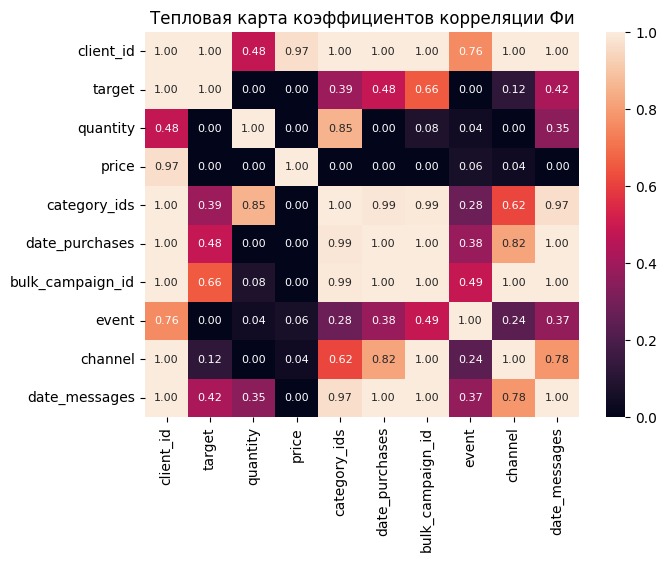

In [649]:
plt.figure(figsize=(7, 5))
sns.heatmap(data_frame.sample(1000, random_state=RANDOM_STATE).phik_matrix(interval_cols=interval_cols),\
            annot=True, fmt='.2f', annot_kws={"fontsize":8})
plt.title('Тепловая карта коэффициентов корреляции Фи');

## Подготовка данных к обучению

In [650]:
data_frame.drop(['client_id', 'date_purchases', 'date_messages'], axis=1, inplace=True)

In [651]:
# После удаления столбца client_id удалим дубликаты
data_frame.drop_duplicates(inplace=True)
data_frame = data_frame.reset_index(drop=True)

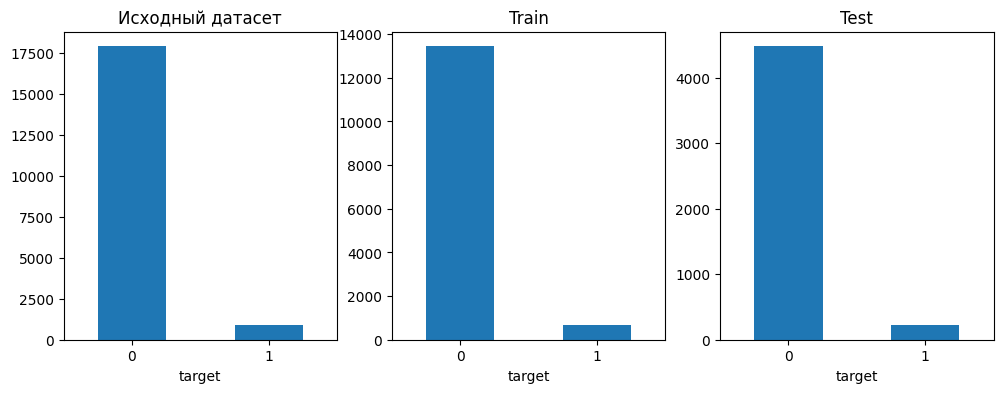

In [652]:
# выделяем в отдельные переменные целевой признак и входные признаки
X = data_frame.drop(columns=['target'], axis=1)
y = data_frame['target']

# разбиваем данные на выборки с учётом стратификации по целевому признаку
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=y
)

# визуализируем баланс целевого признака в выборках
fig, ax = plt.subplots(1,3, figsize=(12,4))
y.value_counts().plot(kind='bar', ax=ax[0], rot=0)
ax[0].set_title("Исходный датасет")
y_train.value_counts().plot(kind='bar', ax=ax[1], rot=0)
ax[1].set_title("Train")
y_test.value_counts().plot(kind='bar', ax=ax[2], rot=0)
ax[2].set_title("Test")
plt.show()

Видим дисбаланс классов!  
Учтем это при подборе гиперпараметров (укажем class_weight='balanced')

In [653]:
# Выделим категориальные признаки
categorial = []
for col in X:
    if data_frame[col].dtype == 'object':
        categorial.append(col)

In [654]:
# OHEncoder
encoder = OneHotEncoder()
encoder.fit(X_train[categorial])

OneHotEncoder()

In [655]:
# Преобразование кат. признаков через OHE
X_train_encode = pd.DataFrame(encoder.transform(X_train[categorial]).toarray(), index = X_train.index)
X_test_encode = pd.DataFrame(encoder.transform(X_test[categorial]).toarray(), index = X_test.index)

In [656]:
# Удалим все категориалные признаки
X_train = X_train.drop(X_train[categorial], axis=1)
X_test = X_test.drop(X_test[categorial], axis=1)

In [657]:
# Соединим по индексу
X_train = X_train.join(X_train_encode)
X_test = X_test.join(X_test_encode)

### Масштабирование  
сначала обучим кодировщик на обучающих признаках а тестовую просто трансформируем

In [658]:
# Переведем все названия столбцов в строковый тип (это важно для Scaler,)
X_train.columns = X_train.columns.astype('str')
X_test.columns = X_test.columns.astype('str')

In [659]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [660]:
# Преобразование
X_train = pd.DataFrame(data=scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns = X_test.columns)

### Простые модели (LogisticRegression, DesTreeClass, RandForestClass)


In [661]:
# гиперпараметры для LogisticRegression
model_logistic = LogisticRegression(random_state=RANDOM_STATE, n_jobs = -1)
params_logistic = {

    'C': [.1, 1, 2, 3, 5, 10, 12],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'class_weight': ['balanced', None],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

In [662]:
%%time
warnings.simplefilter("ignore")
# Подбор лучших гиперпараметров и CV
rs_logistic = RandomizedSearchCV(model_logistic, params_logistic, cv=5, scoring='roc_auc', random_state=RANDOM_STATE)
rs_logistic.fit(X_train, y_train)
print(rs_logistic.best_params_)

{'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None, 'C': 12}
CPU times: user 55 s, sys: 4.06 s, total: 59.1 s
Wall time: 1min 8s


In [663]:
# Лучшие гиперпараметры для logistic regression

logistic_best_params = {
    'solver': ['liblinear'],
    'penalty': ['l1'],
    'class_weight': ['balanced'],
    'C': [2]
}

In [664]:
# гиперпараметры для DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
params_tree = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': range(1, 21),
    'class_weight': ['balanced', None],
    'splitter': ['best', 'random']
}

In [665]:
%%time
# Подбор лучших гиперпараметров и CV
rs_tree = RandomizedSearchCV(model_tree, params_tree, cv=5, scoring='roc_auc', random_state=RANDOM_STATE)
rs_tree.fit(X_train, y_train)
print(rs_tree.best_params_)

{'splitter': 'best', 'max_depth': 13, 'criterion': 'gini', 'class_weight': 'balanced'}
CPU times: user 10.9 s, sys: 543 ms, total: 11.4 s
Wall time: 11.6 s


In [666]:
# Лучшие гиперпараметры для DecisionTreeClassifier
tree_best_params = {
    'splitter': ['random'],
    'max_depth': [10],
    'criterion': ['entropy'],
    'class_weight': ['balanced']
}

In [667]:
# гиперпараметры для RandomForestClassifier
model_forest = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs = -1)
params_forest = {
    'n_estimators': range(100, 1000, 100),
    'max_depth': range(1, 20),
    'max_features': ['log2', 'sqrt', None],
    'min_samples_leaf': range(1, 11),
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]
}

In [668]:
%%time

# Подбор лучших гиперпараметров и CV
rs_forest= RandomizedSearchCV(model_forest, params_forest, cv=5, scoring='roc_auc', random_state=RANDOM_STATE)
rs_forest.fit(X_train, y_train)
print(rs_forest.best_params_)

{'n_estimators': 600, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 16, 'class_weight': 'balanced', 'bootstrap': False}
CPU times: user 14min 31s, sys: 8.36 s, total: 14min 39s
Wall time: 9min 44s


In [669]:
# Лучшие гиперпараметры RandomForest

forest_best_params = {
    'n_estimators': [900],
    'min_samples_leaf': [9],
    'max_features': ['sqrt'],
    'max_depth': [20],
    'class_weight': ['balanced'],
    'bootstrap': [True]
}

### Бустинг (Lgbm, Catboost)

In [670]:
# Параметры для LGBMClassifier
model_lgbm = LGBMClassifier()
lgbm_params = {
    'max_depth': range(2, 21),
    'num_leaves': range(2,50),
    'learning_rate': np.arange(0.1,1,0.1),
    'n_estimators': range(100, 1000, 100),
    'class_weight': ['balanced', None]
}

In [671]:
%%time
# Подбор лучших гиперпараметров и CV
rs_lgbm = RandomizedSearchCV(model_lgbm, lgbm_params, cv=5, scoring='roc_auc', n_jobs=-1, random_state=RANDOM_STATE)
rs_lgbm.fit(X_train, y_train)
print(rs_lgbm.best_params_)

[LightGBM] [Info] Number of positive: 679, number of negative: 13437
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 14116, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048101 -> initscore=-2.985146
[LightGBM] [Info] Start training from score -2.985146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
{'num_leaves': 44, 'n_estimators': 500, 'max_depth': 14, '

In [672]:
# Лучшие Гиперпараметры для LGBM
lgbm_best_params = {
    'num_leaves': [44],
    'n_estimators': [500],
    'max_depth': [14],
    'learning_rate': [0.2],
    'class_weight': [None]
}

In [673]:
# Гиперпараметры для CatBoostClassifier
cat_models = CatBoostClassifier(verbose=False)
cat_params = {
    'depth': range(2,6),
    'learning_rate': np.arange(.01, 0.1, .01),
    'iterations': range(100, 1000, 100),
    'loss_function': ['Logloss', 'CrossEntropy']
}

In [674]:
%%time
# Подбор лучших гиперпараметров и CV
rs_cat = RandomizedSearchCV(cat_models, cat_params, cv=5, n_jobs=-1, scoring='roc_auc', random_state=RANDOM_STATE)
rs_cat.fit(X_train, y_train, verbose=0)
print(rs_cat.best_params_)

{'loss_function': 'CrossEntropy', 'learning_rate': 0.09, 'iterations': 600, 'depth': 5}
CPU times: user 8.36 s, sys: 783 ms, total: 9.15 s
Wall time: 3min 17s


In [675]:
# Лучшие Гиперпараметры для CatBoost:
cat_best_params = {
    'loss_function': ['CrossEntropy'],
    'learning_rate': [0.09],
    'iterations': [600],
    'depth': [5]
}

### Обучение моделей и Кроссвалидация (GridSearchCV)


-Проверим на адекватность с помощью DummyClassifier  
-Обучим выбранные модели, CV с помощью GridSearchCV  
-Посмотрим на время обучения и предсказания каждой модели  
-Рассчитаем Метрики (ROC_AUC, F1, Accuracy)  
-Добавим визуализацию (Матрица ошибок и ROC_curve)  
-Проверим лучшую модель на тестовой выборке.  
-Посмотрим на важность признаков для лучшей модели  

In [676]:
# Константная модель
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_train)
print(f'ROC_AUC у константной модели: {roc_auc_score(y_train, dummy_pred)}')

ROC_AUC у константной модели: 0.5


### Обучение выбранных моделей

In [677]:
# Добавим модели и лучшие гиперпараметры в списки

model_list = [
    model_logistic,
    model_tree,
    model_forest
]
best_params_list = [
    logistic_best_params,
    tree_best_params,
    forest_best_params]

# Список с названиями моделей
name_list = ['LogisticRegression', 'DecisionTree', 'RandomForest']


LogisticRegression
Время обучения: 16.162956476211548
Время предсказания: 10.842666864395142
AUC_ROC: 0.8095578476792747
f1-мера: 0.0318840579710145
Accuracy: 0.952677812411448


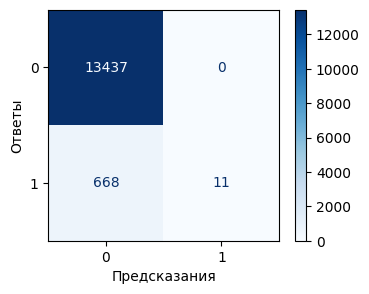

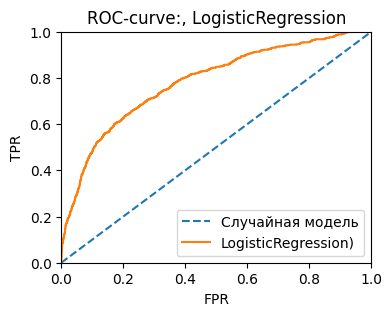


DecisionTree
Время обучения: 1.6996259689331055
Время предсказания: 3.0566980838775635
AUC_ROC: 0.6774218508928506
f1-мера: 0.8305597579425114
Accuracy: 0.984131482006234


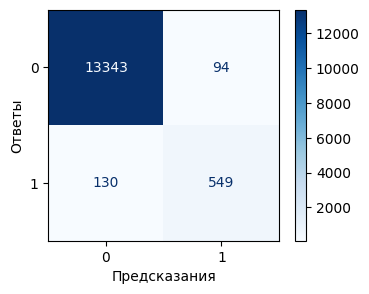

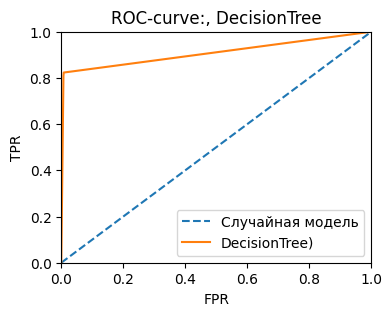


RandomForest
Время обучения: 90.72610902786255
Время предсказания: 22.522865772247314
AUC_ROC: 0.7826805109870408
f1-мера: 0.41219768664563616
Accuracy: 0.9603995466137716


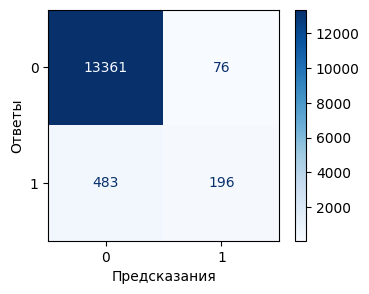

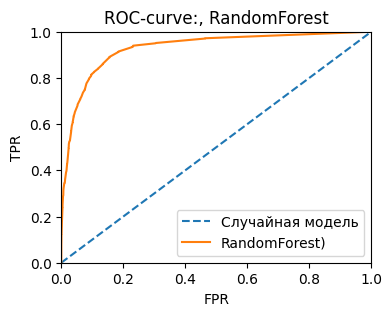

In [678]:
# Выберем лучшие модели с помощью CV (Быстрые модели)

grid_best_score_list = []
grid_model_list = []
predictions = []
timing = []
timing_pred = []
f1_list = []
accuracy_list = []


for n, model in enumerate(model_list):

    grid_model = GridSearchCV(model, best_params_list[n], scoring = 'roc_auc')
    start = time.time() # Засекаем время обучения
    grid_model.fit(X_train, y_train)
    end = time.time() # Стоп
    timing.append(end-start)

    # Время предсказания
    start_pred = time.time()
    grid_model_predictions = cross_val_predict(model, X_train, y_train, cv=5)
    end_pred = time.time()
    predictions.append(grid_model_predictions)
    timing_pred.append(end_pred - start_pred)
    print()
     # Вероятности
    probabilities = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba')
    probabilities_ones = probabilities[:,1]

        # Рассчет метрик
    auc_roc_train = grid_model.best_score_
    fpr, tpr, thresholds = roc_curve(y_train, probabilities_ones)

    f1 = f1_score(y_train, grid_model_predictions, zero_division=0)
    f1_list.append(f1)
    accuracy = accuracy_score(y_train, grid_model_predictions)
    accuracy_list.append(accuracy)

    print(name_list[n])
    print(f'Время обучения: {end - start}')
    print(f'Время предсказания: {end_pred - start_pred}')
    print(f'AUC_ROC: {grid_model.best_score_}')
    print(f'f1-мера: {f1}')
    print(f'Accuracy: {accuracy}')

    # Матрица Ошибок
    fig, ax = plt.subplots(figsize = (4,3))
    cm = confusion_matrix(y_train, predictions[n], labels = (0,1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=(0,1))
    disp.plot(cmap=plt.cm.Blues, ax = ax)

    plt.xlabel('Предсказания')
    plt.ylabel('Ответы')
    plt.show()

        # Графики ROC-curve
    fig,ax = plt.subplots(figsize = (4,3))
    # ROC-curve Случайной модели
    ax.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),label = 'Случайная модель',ls = '--')

    # ROC-curve лучших моделей
    ax.plot(fpr,tpr,
            label = f'{name_list[n]})')
    ax.legend()
    ax.set_title(f'ROC-curve:, {name_list[n]}')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    plt.show()



    grid_best_score_list.append(grid_model.best_score_)
    grid_model_list.append(grid_model.best_estimator_)

In [679]:
# Добавим модели и лучшие гиперпараметры в списки
boosting_list = [model_lgbm, cat_models]
boosting_best_params = [
    lgbm_best_params,
    cat_best_params
]

# Список с названиями моделей
name_boosting = ['LGBM', 'CatBoost']

[LightGBM] [Info] Number of positive: 543, number of negative: 10749
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 11292, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048087 -> initscore=-2.985459
[LightGBM] [Info] Start training from score -2.985459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 544, number of negative: 10749
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ov

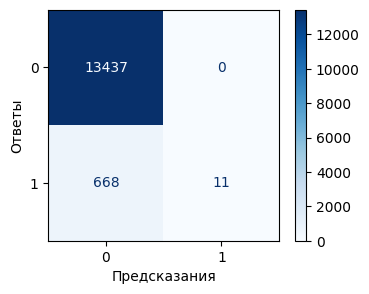

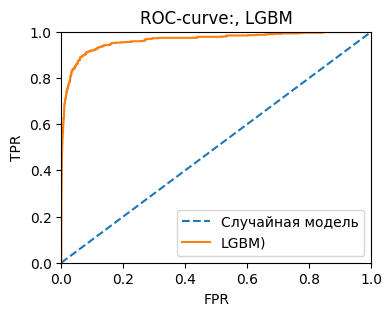


CatBoost
Время обучения: 25.750558853149414
Время предсказания: 36.369871616363525
AUC_ROC: 0.9500884905229814
f1-мера: 0.5415778251599147
Accuracy: 0.9695381127798243


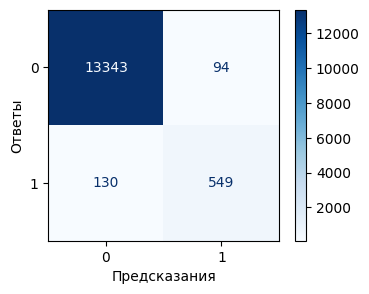

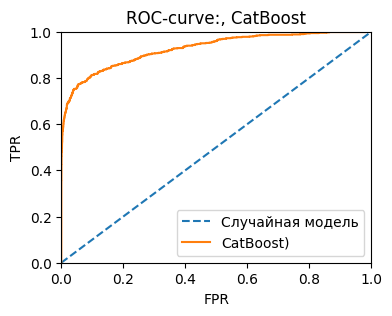

In [680]:
# Выберем лучшие модели с помощью CV (boosting)

grid_best_score_boost = []
grid_model_boost = []


for n, model in enumerate(boosting_list):

    grid_model = GridSearchCV(model, boosting_best_params[n], scoring = 'roc_auc')
    start = time.time() # Засекаем время обучения
    grid_model.fit(X_train, y_train)
    end = time.time() # Стоп
    timing.append(end-start)

    # Время предсказания
    start_pred = time.time()
    grid_model_predictions = cross_val_predict(model, X_train, y_train, cv=5)
    predictions.append(grid_model_predictions)
    end_pred = time.time()
    timing_pred.append(end_pred - start_pred)
    print()

    # Вероятности
    probabilities = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba')
    probabilities_ones = probabilities[:,1]

    # Рассчет метрик
    auc_roc_train = grid_model.best_score_
    fpr, tpr, thresholds = roc_curve(y_train, probabilities_ones)

    f1 = f1_score(y_train, grid_model_predictions, zero_division=0)
    f1_list.append(f1)
    accuracy = accuracy_score(y_train, grid_model_predictions)
    accuracy_list.append(accuracy)

    print(name_boosting[n])
    print(f'Время обучения: {end - start}')
    print(f'Время предсказания: {end_pred - start_pred}')
    print(f'AUC_ROC: {grid_model.best_score_}')
    print(f'f1-мера: {f1}')
    print(f'Accuracy: {accuracy}')

    # График Матрицы ошибок
    fig, ax = plt.subplots(figsize = (4,3))
    cm = confusion_matrix(y_train, predictions[n], labels = (0,1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=(0,1))
    disp.plot(cmap=plt.cm.Blues, ax = ax)

    plt.xlabel('Предсказания')
    plt.ylabel('Ответы')
    plt.show()

    # Графики ROC-curve
    fig,ax = plt.subplots(figsize = (4,3))
    # ROC-curve Случайной модели
    ax.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),label = 'Случайная модель',ls = '--')

    # ROC-curve лучших моделей
    ax.plot(fpr,tpr,
            label = f'{name_boosting[n]})')
    ax.legend()
    ax.set_title(f'ROC-curve:, {name_boosting[n]}')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    plt.show()

    grid_best_score_boost.append(grid_model.best_score_)
    grid_model_boost.append(grid_model.best_estimator_)

In [681]:
# Добавим значения в общий список
grid_best_score_list.extend(grid_best_score_boost)
grid_model_list.extend(grid_model_boost)
name_list.extend(name_boosting)

time_models = np.array(timing)
time_pred = np.array(timing_pred)

In [682]:
for n, value in enumerate(grid_best_score_list):
    print()
    print(f'ROC_AUC модели: {name_list[n]}: {value:.03f}')
    if value > 0.85:
        print(f'Модель {name_list[n]}, подходит под условие проекта')
    elif value <= 0.85:
        print(f'Модель {name_list[n]} не подходит')

    print(f'Время обучения: {time_models[n]:.03f} sec.')
    print(f'Время Предсказания: {time_pred[n]:.03f} sec.')


ROC_AUC модели: LogisticRegression: 0.810
Модель LogisticRegression не подходит
Время обучения: 16.163 sec.
Время Предсказания: 10.843 sec.

ROC_AUC модели: DecisionTree: 0.677
Модель DecisionTree не подходит
Время обучения: 1.700 sec.
Время Предсказания: 3.057 sec.

ROC_AUC модели: RandomForest: 0.783
Модель RandomForest не подходит
Время обучения: 90.726 sec.
Время Предсказания: 22.523 sec.

ROC_AUC модели: LGBM: 0.975
Модель LGBM, подходит под условие проекта
Время обучения: 7.795 sec.
Время Предсказания: 1.481 sec.

ROC_AUC модели: CatBoost: 0.950
Модель CatBoost, подходит под условие проекта
Время обучения: 25.751 sec.
Время Предсказания: 36.370 sec.


In [683]:
# Для Наглядности соберем показатели в табличку
report = pd.DataFrame(columns = name_list, index = ['ROC_AUC', 'F1-мера', 'Accuracy', 'Скорость Обучения (sec)', 'Скорость Прогноза (sec)'])
report.loc['ROC_AUC',:] = grid_best_score_list
report.loc['F1-мера',:] = f1_list
report.loc['Accuracy',:] = accuracy_list
report.loc['Скорость Обучения (sec)',:] = time_models
report.loc['Скорость Прогноза (sec)',:] = time_pred
report

,LogisticRegression,DecisionTree,RandomForest,LGBM,CatBoost
ROC_AUC,0.809558,0.677422,0.782681,0.975373,0.950088
F1-мера,0.031884,0.83056,0.412198,0.580645,0.541578
Accuracy,0.952678,0.984131,0.9604,0.97053,0.969538
Скорость Обучения (sec),16.162956,1.699626,90.726109,7.795118,25.750559
Скорость Прогноза (sec),10.842667,3.056698,22.522866,1.48121,36.369872


In [684]:
best_model_idx = grid_best_score_list.index(max(grid_best_score_list))
print(f'Лучшая модель: {name_list[best_model_idx]}')
print(f'ROC_AUC Лучшей модели: {grid_best_score_list[best_model_idx]}')

Лучшая модель: LGBM
ROC_AUC Лучшей модели: 0.9753734907417796


### Выбор Лучшей модели и проверка на тестовой выборке


In [685]:
best_model = grid_model_list[best_model_idx]

In [686]:
# Проверим качество лучшей модели на тестовой выборке
best_model_pred = best_model.predict(X_test)
# Вероятности
best_model_probabilities = best_model.predict_proba(X_test)
best_model_probabilities_ones = best_model_probabilities[:,1]

# Рассчет метрик
auc_roc_test = roc_auc_score(y_test, best_model_probabilities_ones)
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, best_model_probabilities_ones)
f1_best = f1_score(y_test, best_model_pred, zero_division=0)
accuracy_best = accuracy_score(y_test, best_model_pred)
print(f'AUC_ROC Лучшей модели на тестовой выборке: {auc_roc_test}')
print(f'F1 Лучшей модели на тестовой выборке: {f1_best}')
print(f'Accuracy Лучшей модели на тестовой выборке: {accuracy_best}')

AUC_ROC Лучшей модели на тестовой выборке: 0.9969727797092287
F1 Лучшей модели на тестовой выборке: 0.8968609865470851
Accuracy Лучшей модели на тестовой выборке: 0.9902252443688908


### Визуализация результатов


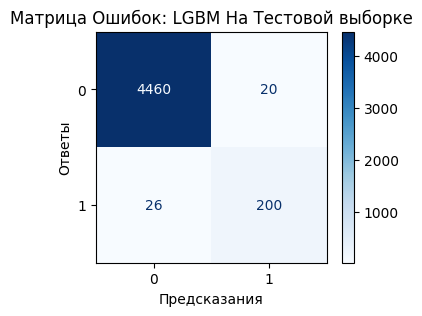

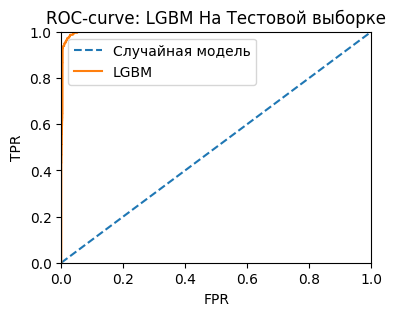

In [687]:
# График Матрицы ошибок
fig, ax = plt.subplots(figsize = (4,3))
ax.set_title(f'Матрица Ошибок: {name_list[best_model_idx]} На Тестовой выборке')
cm = confusion_matrix(y_test, best_model_pred, labels = (0,1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=(0,1))
disp.plot(cmap=plt.cm.Blues, ax = ax)
plt.xlabel('Предсказания')
plt.ylabel('Ответы')
plt.show()

# График ROC-curve
fig,ax = plt.subplots(figsize = (4,3))
# ROC-curve Случайной модели
ax.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),label = 'Случайная модель',ls = '--')

# ROC-curve лучшей модели
ax.plot(fpr_best, tpr_best,
        label = name_list[best_model_idx])
ax.legend()
ax.set_title(f'ROC-curve: {name_list[best_model_idx]} На Тестовой выборке')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.show()

### Важность признаков лучшей модели


In [688]:
# Важность Признаков
print('Важность Признаков')
importance = best_model.feature_importances_
feature_list = list(X_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importance})

# Pначимость признаков
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results.index = feature_results['feature']
feature_results = feature_results.drop(['feature'], axis=1)
feature_results

Важность Признаков


,importance
feature,
bulk_campaign_id,7570
price,7167
423,401
429,379
132,357
...,...
202,0
201,0
200,0


### Визуализация результатов


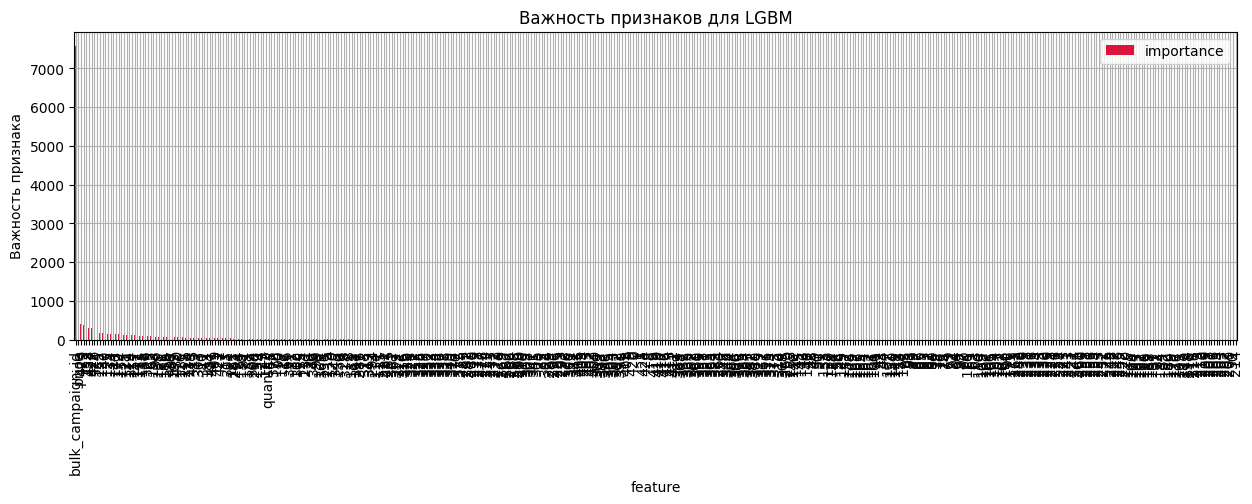

In [689]:
fig, ax = plt.subplots(figsize=(15,4))

feature_results.plot.bar(ax=ax, color='crimson', grid=True)
ax.set_title(f'Важность признаков для {name_list[best_model_idx]}')
ax.set_ylabel('Важность признака')
plt.show()

# Вывод

- Проверили на адекватность с помощью DummyClassifier
- Обучили выбранные модели, CV с помощью GridSearchCV
- Лучшая модель - LGBM
- Проверили лучшую модель на тестовой выборке.
- ROC_AUC = 0.9969727797092287
- Самыq значимые признак для LGBM: bulk_campaign_id.

